In [211]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import datetime as dt
from datetime import date
import pandas_datareader as web
import warnings
warnings.filterwarnings("ignore")

# xgboost
from xgboost import XGBRegressor
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from pickle import dump, load

In [212]:
start = dt.datetime(2021,10,1)
end = dt.datetime(2022,4,29)

# Extract Crypto Price

In [213]:
#read crypto pricing
#extract data from yahoo finance
MANA = web.DataReader('MANA-USD','yahoo', start, end)
SAND = web.DataReader('SAND-USD','yahoo', start, end)
THETA = web.DataReader('THETA-USD','yahoo', start, end)
AXS = web.DataReader('AXS-USD','yahoo', start, end)
STX = web.DataReader('STX-USD','yahoo', start, end)

In [214]:
MANA = MANA.reset_index()
SAND = SAND.reset_index()
THETA = THETA.reset_index()
AXS = AXS.reset_index()
STX = STX.reset_index()

In [215]:
def convert_date(data):
    data.date = pd.to_datetime(data.date)
    data["date"] = data["date"].apply(lambda x: pd.to_datetime(x, unit="ns", utc=True).floor('D').date())
    #data.columns = data.columns.str.replace('Date', 'date')
    return data

In [216]:
MANA.columns = MANA.columns.str.replace('Date', 'date')
SAND.columns = SAND.columns.str.replace('Date', 'date')
THETA.columns = THETA.columns.str.replace('Date', 'date')
AXS.columns = AXS.columns.str.replace('Date', 'date')
STX.columns = STX.columns.str.replace('Date', 'date')

MANA = convert_date(MANA)
SAND = convert_date(SAND)
THETA = convert_date(THETA)
AXS = convert_date(AXS)
STX = convert_date(STX)

In [217]:
#add pct change column to capture daily crypto price change
ClosingPrice = MANA[['Adj Close']]
MANA['pct_change'] = ClosingPrice.pct_change()*100
#add pct change column
ClosingPrice = SAND[['Adj Close']]
SAND['pct_change'] = ClosingPrice.pct_change()*100
#add pct change column
ClosingPrice = THETA[['Adj Close']]
THETA['pct_change'] = ClosingPrice.pct_change()*100
#add pct change column
ClosingPrice = AXS[['Adj Close']]
AXS['pct_change'] = ClosingPrice.pct_change()*100
#add pct change column
ClosingPrice = STX[['Adj Close']]
STX['pct_change'] = ClosingPrice.pct_change()*100

MANA = MANA.set_index('date')
SAND = SAND.set_index('date')
THETA = THETA.set_index('date')
AXS = AXS.set_index('date')
STX = STX.set_index('date')

# Load sentiment score for crypto news and stock market new

In [218]:
news = pd.read_csv(r"Data/text_data/News_sentiment.csv", sep="\t")

In [219]:
def filter_news_sentiment(start, end, data):
    data["date"] = data["date"].apply(lambda x: pd.to_datetime(x, unit="ns", utc=True).floor('D').date())
    crypto_news = data[(data['category'] == 'Cryptocurrencies')].reset_index()
    stocks_market_news = data[(data['category'] == 'Stock Market')].reset_index()
    finance_news = data[(data['category'] == 'Finance')].reset_index()
    #metaverse_news = data[(data['category'] == 'Metaverse')].reset_index()
    
    crypto_news = split_news_category(crypto_news)
    stocks_market_news = split_news_category(stocks_market_news)
    finance_news = split_news_category(finance_news)
    #metaverse_news = split_news_category(metaverse_news, remove_pos_bias, remove_neg_bias)
    
    return crypto_news,stocks_market_news,finance_news

In [220]:
def split_news_category(data):
    #group daily sentiment score
    data = data.drop(['content'], axis=1)
    data = data.groupby(['date'])['sentiment_score'].mean().reset_index().rename(columns={'mean':'sentiment score'})
    data = data.set_index('date') 
    data = data.sort_index() # sort by datetime
    data = data.reset_index()
    
    data = data.set_index('date')
    
    data["sentiment_score_1"] = data.shift(1)
    return data

In [221]:
start_sentiment = dt.datetime(2021,10,1)
end_sentiment = dt.datetime(2022,4,29)

In [250]:
crypto_news, stocks_market_news, finance_news = filter_news_sentiment(start_sentiment, end_sentiment, news)

#remove all the sentiment score left only between -0.5 above or more than 0.5
positive = 0.5
negative = -0.5

crypto_news_filter = crypto_news[(crypto_news['sentiment_score'] > positive) | (crypto_news['sentiment_score'] < negative)]
stocks_market_news_filter = stocks_market_news[(stocks_market_news['sentiment_score'] > positive) | (stocks_market_news['sentiment_score'] < negative)]


# Generated RSI

In [223]:
# Calculate the RSI via pandas_ta
MANA_7_RSI = MANA.ta.rsi(close='Adj Close', length=7, append=True,signal_indicators=True)
MANA_14_RSI = MANA.ta.rsi(close='Adj Close', length=14, append=True,signal_indicators=True)

In [224]:
def pandas_rsi(df: pd.DataFrame, window_length: int = 14, output: str = None, price: str = 'adj close'):
    """
    An implementation of Wells Wilder's RSI calculation as outlined in
    his 1978 book "New Concepts in Technical Trading Systems" which makes
    use of the α-1 Wilder Smoothing Method of calculating the average
    gains and losses across trading periods and the Pandas library.
    @author: https://github.com/alphazwest
    Args:
        df: pandas.DataFrame - a Pandas Dataframe object
        window_length: int - the period over which the RSI is calculated. Default is 14
        output: str or None - optional output path to save data as CSV
        price: str - the column name from which the RSI values are calcuated. Default is 'Close'
    Returns:
        DataFrame object with columns as such, where xxx denotes an inconsequential
        name of the provided first column:
            ['xxx', 'diff', 'gain', 'loss', 'avg_gain', 'avg_loss', 'rs', 'rsi']
    """
    # Calculate Price Differences using the column specified as price.
    df['diff'] = df['adj close'].diff(1)

    # Calculate Avg. Gains/Losses
    df['gain'] = df['diff'].clip(lower=0).round(2)
    df['loss'] = df['diff'].clip(upper=0).abs().round(2)

    # Get initial Averages
    df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
    df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]

    # Calculate Average Gains
    for i, row in enumerate(df['avg_gain'].iloc[window_length+1:]):
        df['avg_gain'].iloc[i + window_length + 1] =\
            (df['avg_gain'].iloc[i + window_length] *
             (window_length - 1) +
             df['gain'].iloc[i + window_length + 1])\
            / window_length

    # Calculate Average Losses
    for i, row in enumerate(df['avg_loss'].iloc[window_length+1:]):
        df['avg_loss'].iloc[i + window_length + 1] =\
            (df['avg_loss'].iloc[i + window_length] *
             (window_length - 1) +
             df['loss'].iloc[i + window_length + 1])\
            / window_length

    # Calculate RS Values
    df['rs'] = df['avg_gain'] / df['avg_loss']

    # Calculate RSI
    df['rsi'] = 100 - (100 / (1.0 + df['rs']))

    # Save if specified
    if output is not None:
        df.to_csv(output)

    return 

In [269]:
MANA.columns = map(str.lower, MANA.columns)
# Make RSI Calculations
pandas_rsi(df=MANA, window_length=14, price='adj close')

SAND.columns = map(str.lower, SAND.columns)
# Make RSI Calculations
pandas_rsi(df=SAND, window_length=14, price='adj close')

THETA.columns = map(str.lower, THETA.columns)
# Make RSI Calculations
pandas_rsi(df=THETA, window_length=14, price='adj close')

AXS.columns = map(str.lower, AXS.columns)
# Make RSI Calculations
pandas_rsi(df=AXS, window_length=14, price='adj close')

STX.columns = map(str.lower, STX.columns)
# Make RSI Calculations
pandas_rsi(df=STX, window_length=14, price='adj close')

# XGBoost prediction model

In [226]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [227]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [265]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    #dump(model,open('Models/predictive/{0}_model.pkl'.format(crypto),'wb'))
    # make a one-step prediction
    yhat = model.predict(np.asarray([testX]))
    return yhat[0]
 

In [260]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        #print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

# MANA

In [263]:
def plot_prediction_result(values, var):
    # transform the time series data into supervised learning
    data = series_to_supervised(values, n_in=var)
    # evaluate
    mae, y, yhat = walk_forward_validation(data, 200)
    print('MAE: %.3f' % mae)
    # plot expected vs preducted
    pyplot.plot(y, label='Expected')
    pyplot.plot(yhat, label='Predicted')
    pyplot.legend()
    pyplot.show()

MAE: 0.234


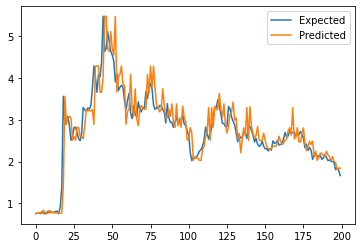

In [266]:
values=MANA[['adj close']].fillna(0).values
plot_prediction_result(values, 1)

In [247]:
mana_merge_data = pd.DataFrame({ 
                            'open': MANA['open'],
                            'rsi': MANA['rsi'],
                            'rs': MANA['rs'],
                            'crypto_sentiment' :  crypto_news.sentiment_score,
                            'stock_market_sentiment': stocks_market_news.sentiment_score,
                            'adj close': MANA['adj close']
                          })

MAE: 0.160


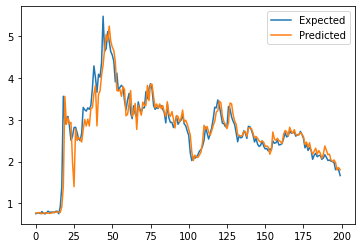

In [248]:
values=mana_merge_data[['rsi', 'rs', 'adj close']].fillna(0).values
plot_prediction_result(values, 3)

MAE: 0.218


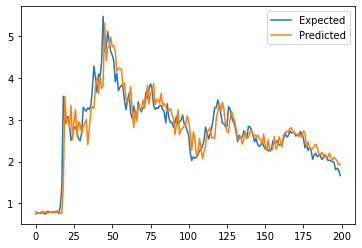

In [267]:
values=mana_merge_data[['crypto_sentiment','stock_market_sentiment', 'adj close']].fillna(0).values
plot_prediction_result(values, 3)

# SAND

MAE: 0.362


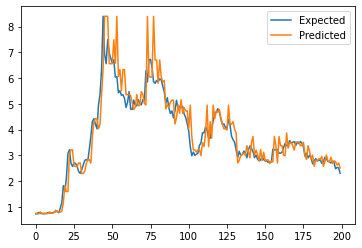

In [270]:
values=SAND[['adj close']].fillna(0).values
plot_prediction_result(values, 1)

In [271]:
sand_merge_data = pd.DataFrame({ 
                            'open': SAND['open'],
                            'rsi': SAND['rsi'],
                            'rs': SAND['rs'],
                            'crypto_sentiment' :  crypto_news.sentiment_score,
                            'stock_market_sentiment': stocks_market_news.sentiment_score,
                            'adj close': SAND['adj close']
                          })

MAE: 0.328


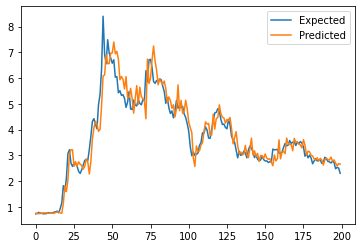

In [272]:
values=sand_merge_data[['crypto_sentiment','stock_market_sentiment', 'adj close']].fillna(0).values
plot_prediction_result(values, 3)

# THETA

MAE: 0.300


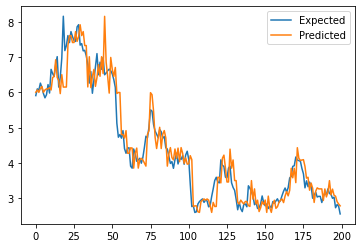

In [273]:
values=THETA[['adj close']].fillna(0).values
plot_prediction_result(values, 1)

In [274]:
theta_merge_data = pd.DataFrame({ 
                            'open': THETA['open'],
                            'rsi': THETA['rsi'],
                            'rs': THETA['rs'],
                            'crypto_sentiment' :  crypto_news.sentiment_score,
                            'stock_market_sentiment': stocks_market_news.sentiment_score,
                            'adj close': THETA['adj close']
                          })

MAE: 0.289


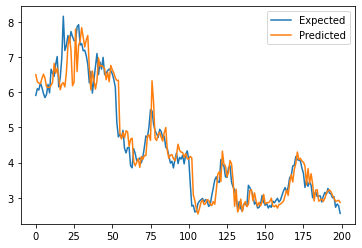

In [275]:
values=theta_merge_data[['crypto_sentiment','stock_market_sentiment', 'adj close']].fillna(0).values
plot_prediction_result(values, 3)

# AXS

MAE: 5.519


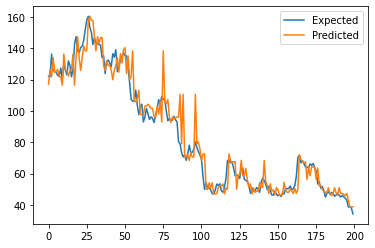

In [276]:
values=AXS[['adj close']].fillna(0).values
plot_prediction_result(values, 1)

In [277]:
axs_merge_data = pd.DataFrame({ 
                            'open': AXS['open'],
                            'rsi': AXS['rsi'],
                            'rs': AXS['rs'],
                            'crypto_sentiment' :  crypto_news.sentiment_score,
                            'stock_market_sentiment': stocks_market_news.sentiment_score,
                            'adj close': AXS['adj close']
                          })

MAE: 4.942


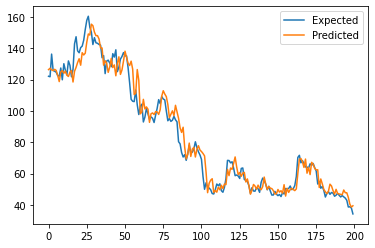

In [278]:
values=axs_merge_data[['crypto_sentiment','stock_market_sentiment', 'adj close']].fillna(0).values
plot_prediction_result(values, 3)

# STX

MAE: 0.124


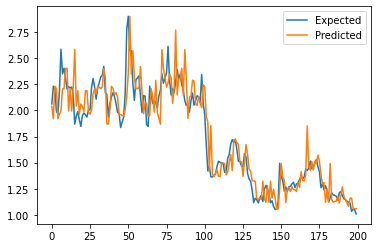

In [279]:
values=STX[['adj close']].fillna(0).values
plot_prediction_result(values, 1)

In [280]:
stx_merge_data = pd.DataFrame({ 
                            'open': STX['open'],
                            'rsi': STX['rsi'],
                            'rs': STX['rs'],
                            'crypto_sentiment' :  crypto_news.sentiment_score,
                            'stock_market_sentiment': stocks_market_news.sentiment_score,
                            'adj close': STX['adj close']
                          })

MAE: 0.108


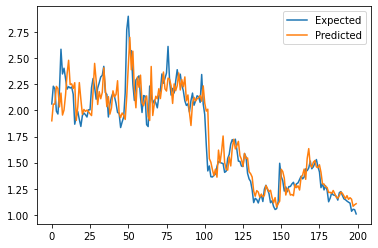

In [281]:
values=stx_merge_data[['crypto_sentiment','stock_market_sentiment', 'adj close']].fillna(0).values
plot_prediction_result(values, 3)